# Assignment 2: Model Creation with SciKit-learn

In this notebook, you will work through a series of exercises designed to deepen your understanding of model creation using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In addition to the coding exercises, there are several open-ended questions that require thoughtful responses. Your answers should be thoroughly **justified** using: (a) Python code, (b) performance metrics, and (c) visualizations. Unsubstantiated responses will receive lower evaluations, so ensure your answers are supported with clear evidence.

In [1]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

The following cell contains two functions for result visualization. **DO NOT MODIFY** them.

You are allowed to reuse parts of this code for the open-ended questions,  but ensure both functions remain unchanged in their original form.

- The `plot_decision_surface` function generates a scatter plot of the training data (as circles) and test data (as diamonds), along with the model's decision boundary.
  
- The `plot_parallel_coordinates` function visualizes the accuracy, precision, recall, and F1-score in relation to the gamma parameter of a Support Vector Machine classifier.
</div>

In [2]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import plotly.graph_objects as go

set_config(transform_output="pandas")

def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def plot_parallel_coordinates(df, svm_models, title):
    df = df.copy()
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.replace({'gamma': {'scale': svm_models['scale']._gamma}})
    dimensions = [
        dict(range=[0, 1],
             label='Accuracy', values=df['accuracy']),
        dict(range=[0, df['gamma'].max()],
             label='Gamma', values=df['gamma']),
        dict(range=[0, 1],
             label='Precision 0', values=df['precision_class_0']),
        dict(range=[0, 1],
             label='Precision 1', values=df['precision_class_1']),
        dict(range=[0, 1],
             label='Recall 0', values=df['recall_class_0']),
        dict(range=[0, 1],
             label='Recall 1', values=df['recall_class_1']),
        dict(range=[0, 1],
             label='F1 0', values=df['f1_class_0']),
        dict(range=[0, 1],
             label='F1 1', values=df['f1_class_1'])
    ]
    if 'dataset_size' in df.columns:
        dimensions.insert(1, dict(range=[0, 2500],
                                   label='Dataset size', values=df['dataset_size'],
                                   tickvals=[250, 2500],
                                   ticktext=['250', '2500']))

    
    fig = go.Figure(
        go.Parcoords(
            line=dict(color=df.index.to_list(), colorscale='Plasma_r', showscale=False),
            dimensions=dimensions
        ))
    fig.update_layout(
        title=title,
        font_size=10
    )
    fig.show()


<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_moons` function from the `sklearn.datasets` module with the parameters: `n_samples=250`, `noise=0.1`, and `random_state=42`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.

<br><i>[0.5 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

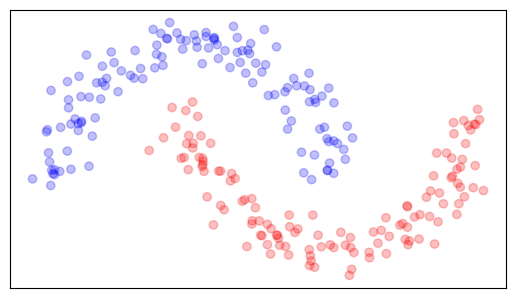

In [3]:
# YOUR CODE HERE
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=250, noise=0.1, random_state=42)
plot_decision_surface(X,y)


In [4]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 1: Train-test split </b>

Write code to split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. After creating the dataset, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

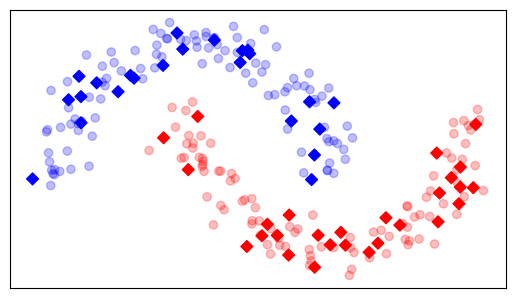

In [5]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
plot_decision_surface(X_train, y_train, X_test, y_test)

In [6]:
# LEAVE BLANK

In [7]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Logistic regression model creation</b>

Write code to fit a logistic regression model to the training data and store the model in a variable called `logistic`. Then, calculate the accuracy for both the training and testing sets, and store the results in `train_accuracy` and `test_accuracy`, respectively.

<br><i>[0.5 points]</i>
</div>


In [8]:
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
train_accuracy = logistic.score(X_train, y_train)
test_accuracy = logistic.score(X_test, y_test)
print(f"Train accuracy: {train_accuracy*100}% \nTest accuracy {test_accuracy*100}%")

Train accuracy: 85.5% 
Test accuracy 90.0%


In [9]:
# LEAVE BLANK

In [10]:
# LEAVE BLANK

In [11]:
# LEAVE BLANK

In [12]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Explain logistic regression decision boundary</b>

Provide substantiated answers to the following questions:

- What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
- Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
- Do you think logistic regression is an appropriate model for this dataset? Why or why not?
- Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

<br><i>[0.5 points]</i>
</div>

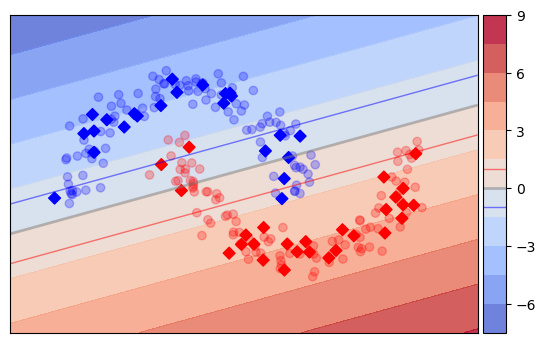

In [13]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

**What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?**

The logistic regression model's decision boundary is linear, but the data’s underlying structure is non-linear, resembling interlocking moons. The issue is that linear regression models can't effectively capture this non-linear pattern, leading to a decision boundary that fails to align with the curved nature of the two classes. Consequently, many points near the center of the moons are likely to be misclassified, indicating that the linear decision boundary does not match well with the non-linear data structure.

*** 

**Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?**

The model underperforms particularly in central regions where the classes curve around each other. This is seen where data points are misclassified on both sides of the boundary and as prevoiusly mentioned, the linear decision boundary fails to capture non-linear relationships. Accuracy alone may not be sufficient here because it does not capture the model’s failure to understand the underlying pattern. In this case, metrics such as the F1-score or recall, could provide better insight into the model's performance.


Test accuracy: 90.0% - Test precision: 89.28571428571429% - Test recall: 92.5925925925926% - Test F1-score: 90.9090909090909%


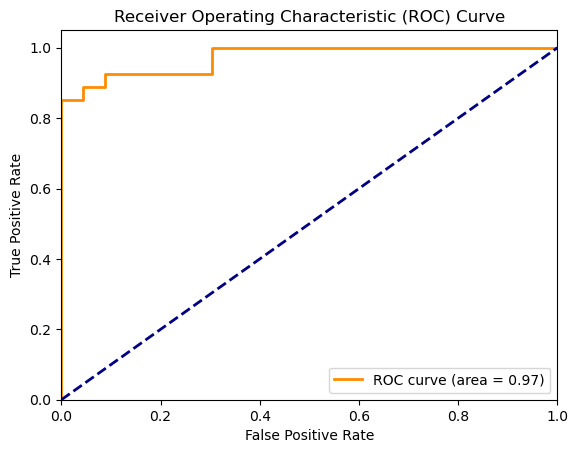

In [14]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc

# Calculate the new metrics
y_pred= logistic.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test accuracy: {test_accuracy*100}% - Test precision: {test_precision*100}% - Test recall: {test_recall*100}% - Test F1-score: {test_f1*100}%")

#Now we plot the ROC curve
import matplotlib.pyplot as plt
y_pred_proba = logistic.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**Do you think logistic regression is an appropriate model for this dataset? Why or why not?**

Logistic regression may not be the best model for this dataset due to its inability to capture the non-linear structure. This logistic regression model does achieve high performance metrics, with 90% accuracy, 89.3% precision, 92.6% recall, and an F1 score of 90.9%. It also demonstrates strong performance on the ROC curve, with an AUC of 0.97. However, despite these metrics, the model is still theoretically unsuitable because of its linear decision boundary. A decision tree, random forest, or SVM with an RBF kernel, would likely perform better by adapting to the dataset's underlying patterns. 

In [15]:
#We check with cross validation to see if the model is overfitting or underfitting

from sklearn.model_selection import cross_val_score

# We perform 5-fold cross-validation
cv_scores = cross_val_score(logistic, X, y, cv=5, scoring='accuracy')
precision_scores = cross_val_score(logistic, X, y, cv=5, scoring='precision')
recall_scores = cross_val_score(logistic, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(logistic, X, y, cv=5, scoring='f1')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")
print(f"Mean Precision: {precision_scores.mean():.2f} - Mean Recall: {recall_scores.mean():.2f} - Mean F1 Score: {f1_scores.mean():.2f}")

Cross-validation scores: [0.92 0.86 0.78 0.84 0.92]
Mean cross-validation score: 0.86
Mean Precision: 0.87 - Mean Recall: 0.86 - Mean F1 Score: 0.86


**Does the model appear to overfit or underfit the data? What evidence supports your conclusion?**

The model seems to underfit the data. Even though the metrics look pretty good after cross-validation, the dataset doesn’t have much noise, which makes it easier for a linear model like logistic regression to work well. However, logistic regression can’t handle the non-linear patterns in the data, especially if there were more noise. This underfitting shows the model’s limited ability to learn the more complex relationships in the data.

<div class="alert alert-info"><b>Exercise 4: Decision tree model creation</b>

Write code to fit a decision tree classifier to the training data and store the model in a variable named `dt`. Next, compute the accuracy, precision, and recall for both the training and testing sets, and store the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, and `test_recall`.

<br><i>[0.5 points]</i>
</div>

In [16]:
# YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predictions for training and testing sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Metrics for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

# Metrics for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"Train accuracy: {train_accuracy*100:.2f}% - Train precision: {train_precision*100:.2f}% - Train recall: {train_recall*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}% - Test precision: {test_precision*100:.2f}% - Test recall: {test_recall*100:.2f}%")


Train accuracy: 100.00% - Train precision: 100.00% - Train recall: 100.00%
Test accuracy: 98.00% - Test precision: 96.43% - Test recall: 100.00%


In [17]:
# LEAVE BLANK

In [18]:
# LEAVE BLANK

In [19]:
# LEAVE BLANK

In [20]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Explain the decision tree classifier decision boundary</b>

Provide well-supported answers to the following questions:

- Why is the decision tree model a good fit for this dataset?
- Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?
- How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?
- What are the strengths and weaknesses of decision trees compared to logistic regression?

<br><i>[0.75 points]</i>
</div>

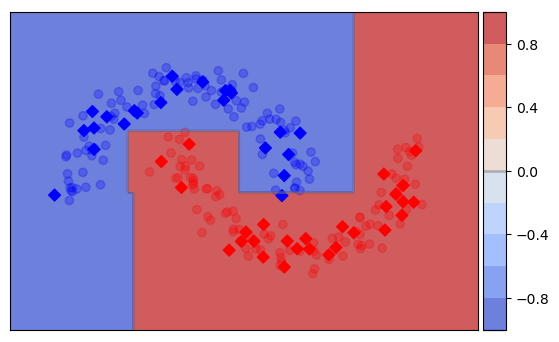

In [21]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, dt)

**Why is the decision tree model a good fit for this dataset?**

The decision tree model is a good fit for this dataset because it can capture complex, non-linear relationships between features. Unlike logistic regression, which creates a linear decision boundary, decision trees can create more flexible and intricate boundaries by splitting the data multiple times based on feature values. This allows the model to adapt well to the "interlocking moons" pattern seen in the data.

***
**Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?**

The decision boundary of a decision tree often looks like a heaviside step function (staircase like) because the model makes decisions based on splitting the data at certain threshold values of the features. Each split creates a region in the feature space with a constant prediction, leading to sharp, axis-aligned boundaries. This structure can contribute to overfitting, especially if the tree is very deep. A deep tree can memorize the training data, capturing noise along with the signal, which is why we might see the perfect training accuracy (100%) and slightly lower but still high testing accuracy (98%). Overfitting is visible in regions where the decision tree may create overly complex splits to correctly classify all training points but doesn't generalize as well to new data.

***
**How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?**

Decision boundaries produced by decision trees are piecewise and axis-aligned, meaning they create rectangular regions in the feature space where the predictions are constant. This allows them to capture intricate non-linear patterns more effectively than logistic regression. Logistic regression, on the other hand, produces a linear decision boundary, which can struggle with non-linear relationships and is less flexible in adapting to complex data patterns.

***
**What are the strengths and weaknesses of decision trees compared to logistic regression?**

Decision trees excel at handling non-linear relationships and are easy to interpret and visualize. They can manage both numerical and categorical data without the need for feature scaling. However, they are prone to overfitting, which can result in overly complex models that do not generalize well to new data. Decision trees can also be sensitive to small variations in the data. On the other hand, logistic regression is simpler and easier to implement, making it suitable for binary classification problems with linear decision boundaries. However, logistic regression assumes a linear relationship between features and the target variable, which may not always be the case. It is more prone to underfitting. It can struggle with non-linear patterns unless significant feature transformations are applied, and its performance heavily depends on the correct specification of the model.



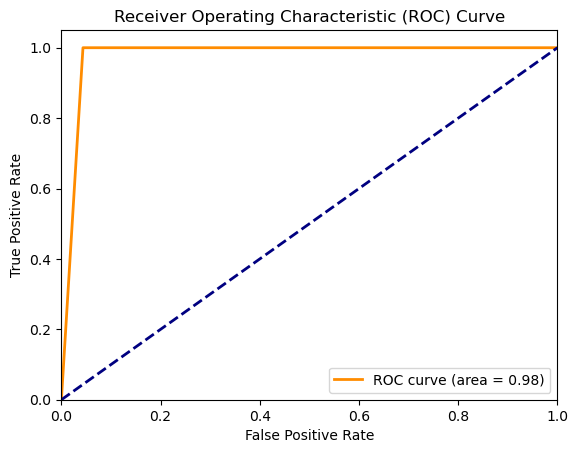

Cross-validation scores: [0.98 0.94 1.   0.96 1.  ]
Mean cross-validation score: 0.98
Mean Precision: 0.98 - Mean Recall: 0.98 - Mean F1 Score: 0.98


In [22]:
# Now we check the same metrics and plots for this model
# Calculate the probabilities for the ROC curve
y_pred_proba = dt.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# We perform 5-fold cross-validation
cv_scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
precision_scores = cross_val_score(dt, X, y, cv=5, scoring='precision')
recall_scores = cross_val_score(dt, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(dt, X, y, cv=5, scoring='f1')

# Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")
print(f"Mean Precision: {precision_scores.mean():.2f} - Mean Recall: {recall_scores.mean():.2f} - Mean F1 Score: {f1_scores.mean():.2f}")



With an ROC AUC of 0.98, our decision tree model shows good performance in distinguishing between classes, indicating robust classification and good generalization to new data. However, it’s important to be aware that despite the high AUC, decision trees can still overfit if not properly pruned or regularized, especially in datasets with complex patterns or noise.
Following 5-fold cross-validation, we find that the model consistently delivers strong performance across various train-test splits, suggesting the dataset's low level of noise.

<div class="alert alert-info"><b>Exercise 6: Support vector machine model creation </b>

Write code to fit a Support Vector Machine (SVM) classifier with an RBF kernel to the training data and store the model in a variable named `svm`. Then, calculate the accuracy, precision, recall, and F1-score for both the training and testing sets, storing the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, `test_recall`, and `test_f1`.

<br><i>[0.5 points]</i>
</div>


In [23]:
# YOUR CODE HERE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Metrics for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)   ## We store it as a variable even though the instruction doesn't say so 

# Metrics for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train accuracy: {train_accuracy*100:.2f}% - Train precision: {train_precision*100:.2f}% - Train recall: {train_recall*100:.2f}% - Train F1-score: {train_f1*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}% - Test precision: {test_precision*100:.2f}% - Test recall: {test_recall*100:.2f}% - Test F1-score: {test_f1*100:.2f}%")


Train accuracy: 100.00% - Train precision: 100.00% - Train recall: 100.00% - Train F1-score: 100.00%
Test accuracy: 100.00% - Test precision: 100.00% - Test recall: 100.00% - Test F1-score: 100.00%


In [24]:
# LEAVE BLANK

In [25]:
# LEAVE BLANK

In [26]:
# LEAVE BLANK

In [27]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Explain the  support vector machine model decision boundary</b>

Provide well-reasoned answers to the following questions:

- Why is the SVM a good fit for this dataset?
- How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?
- Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?
- How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?
- What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?
- In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?
- How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

<br><i>[1 points]</i>
</div>

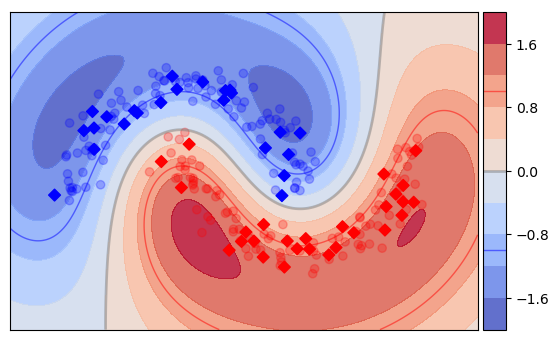

In [28]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

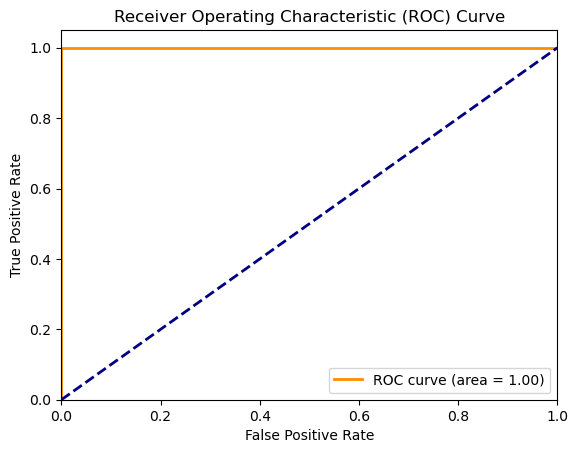

In [29]:
# Calculate the probabilities for the ROC curve
y_pred_proba = svm.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Why is the SVM a good fit for this dataset?**

The SVM is a good fit for this dataset because it can effectively handle the non-linear patterns present in the data by using the Radial Basis Function (RBF) kernel. This allows the model to create a flexible decision boundary that can separate complex, interlocking classes, resulting in perfect classification accuracy as seen in the results. In this scenario, we achieve 100% in all metrics due to the dataset's virtually noise-free nature, resulting in a flawless ROC curve with an AUC of 1 as presented in the plot above.
***
**How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?**

Support vectors are the data points that are closest to the decision boundary. They determine the position and orientation of the boundary. These points are crucial because the SVM optimizes the decision boundary to maximize the margin (distance) between the support vectors from different classes. This focus on the margin ensures that the model is not only effective in classification but also robust to overfitting, as it generalizes well to new data.
***
**Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?**

SVMs produce a smooth, continuous decision boundary because they aim to maximize the margin between classes. The RBF kernel further allows the model to create a non-linear, smooth boundary by mapping the original features into a higher-dimensional space. In contrast, decision trees create 'blocky' boundaries because they make decisions by recursively partitioning the feature space into axis-aligned regions based on threshold values.
***
**How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?**

SVM decision boundaries, especially with non-linear kernels like RBF, are flexible and can curve to fit complex patterns in the data. Logistic regression, however, creates a linear decision boundary, which means it can only separate data with a straight line. This makes SVM more suitable for datasets with non-linear separations, whereas logistic regression is better for linearly separable data.

We can see in the next code how different kernels affects directly the results of the analysis

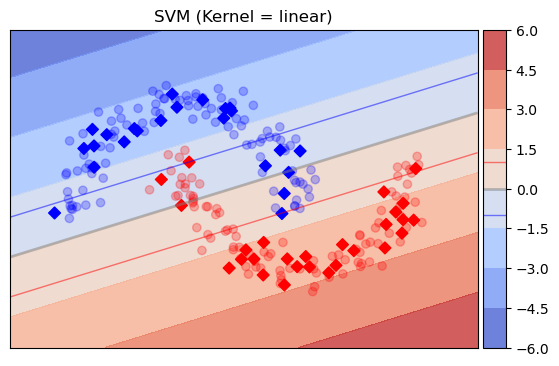

{'test_accuracy': 90.0, 'test_precision': 89.29, 'test_recall': 92.59, 'test_f1': 90.91}


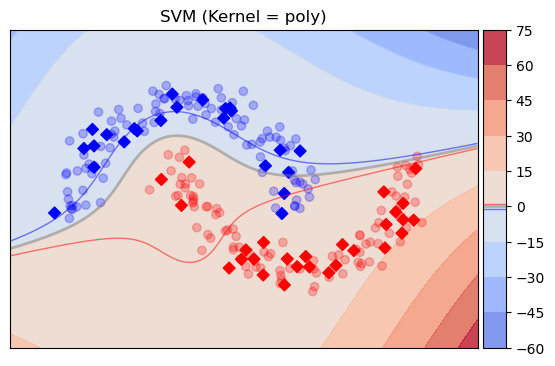

{'test_accuracy': 96.0, 'test_precision': 93.1, 'test_recall': 100.0, 'test_f1': 96.43}


In [30]:
# We can try different kernels:
kernels = ["linear", "poly"]
results = {}

for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)

    y_test_pred = svm.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results[kernel] = {
        "test_accuracy": round(test_accuracy * 100, 2),
        "test_precision": round(test_precision * 100, 2),
        "test_recall": round(test_recall * 100, 2),
        "test_f1": round(test_f1 * 100, 2)
    }
    
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f"SVM (Kernel = {kernel})")
    print(results[kernel])


**What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?**

Support Vector Machines (SVM) effectively handle high-dimensional data and excel in dealing with non-linear patterns using kernels like RBF. They are robust to overfitting when a clear margin is present. However, SVMs can be computationally intensive for large datasets and require careful hyperparameter tuning. In comparison, logistic regression is simpler, easier to interpret, and provides probabilistic outputs, but it assumes a linear relationship and may struggle with non-linear patterns. Decision trees are easy to interpret and handle both numerical and categorical data without feature scaling, but they can overfit if not pruned and are sensitive to small data variations.
***
**In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?**

Logistic regression is more suitable for binary classification problems with linearly separable data and when model interpretability and computational efficiency are crucial. It works well in scenarios where the relationship between features and the target variable is expected to be linear. On the other hand, SVM is a better choice for datasets with complex, non-linear patterns and high-dimensional spaces, where a flexible decision boundary is necessary to achieve high accuracy. SVMs are preferred when robustness to overfitting and the ability to generalize well to new data are important considerations.
***
**How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?**

Support vectors shape the SVM's decision boundary by determining its position and orientation to maximize the margin between classes. This method focuses on a few critical data points, ensuring the model is both accurate and robust. In contrast, decision trees use a recursive partitioning method, splitting the data into subsets based on feature values. This approach creates hierarchical, axis-aligned regions, leading to the 'blocky' decision boundaries that can be complex but may overfit the data if not carefully managed.

<div class="alert alert-info"><b>Exercise 8: Generating a Noisy Dataset</b>

The dataset used in the previous exercies had an easy and well-defined decision boundary. However, real business datasets contains noise and errors, making the classification task more complex and intrincate. To generate a more realistic dataset, write code to generate a new feature matrix `X` and a target array `y` using the `make_moons` function with the parameters: `n_samples=250`, `noise=0.4`, and `random_state=42`. Then, split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. Finally, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the new train and test data distribution.

<br><i>[0.25 points]</i>
</div>

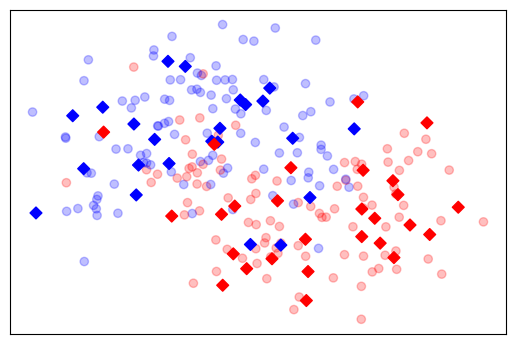

In [31]:
# YOUR CODE HERE
X, y = make_moons(n_samples=250, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test)

In [32]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 9: Analyzing the potential negative impact of noisy datasets</b>

Provide well-supported answers to the following questions:

- How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?
- How might the logistic regression model be affected by noisy data?
- How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?
- How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?
- What strategies can be used to mitigate the effects of noise on these models?

<br><i>[0.75 points]</i>
</div>

**How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?**

Increased noise in the dataset will likely reduce the performance of all models, reflected in decreased metrics. Noise complicates the learning process by introducing more overlapping and potentially mislabeled data points, making it harder for models to discern the underlying patterns. Among the models, the SVM with an RBF kernel is expected to handle noise better. This is because it focuses on maximizing the margin around the decision boundary, thereby minimizing the influence of noisy points that are far from this margin. The RBF kernel operates in higher dimensions, effectively acting like a Weighted Nearest Neighbor model, where the closest observations significantly influence the classification of new observations. This helps the SVM maintain robust performance even in noisy conditions.
***
**How might the logistic regression model be affected by noisy data?**

Logistic regression is likely to be significantly affected by noisy data. As a model that assumes a linear relationship between the features and the target variable, logistic regression can struggle when noise is introduced. This is because noise can lead to overlapping data points and mislabeled instances, which complicates the model's ability to draw a clear, linear decision boundary. Consequently, the model's accuracy and other performance metrics may decrease. We can see the results in the following code:

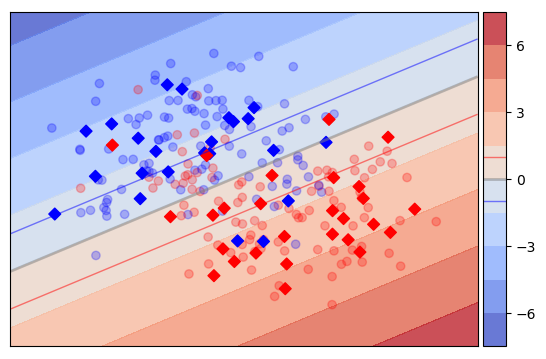

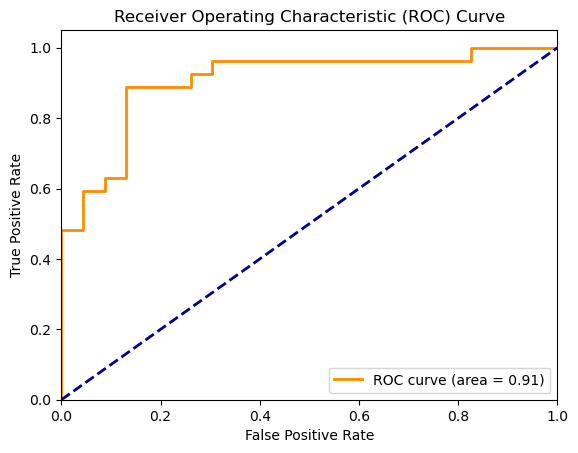

Test accuracy: 86.00% - Test precision: 85.71% - Test recall: 88.89%
Cross-validation scores: [0.88 0.72 0.78 0.84 0.82]
Mean cross-validation score: 0.81
Mean Precision: 0.82 - Mean Recall: 0.79 - Mean F1 Score: 0.80


In [33]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

y_pred_proba = logistic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Metrics
y_test_pred = logistic.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"Test accuracy: {test_accuracy*100:.2f}% - Test precision: {test_precision*100:.2f}% - Test recall: {test_recall*100:.2f}%")
# We perform 5-fold cross-validation
cv_scores = cross_val_score(logistic, X, y, cv=5, scoring='accuracy')
precision_scores = cross_val_score(logistic, X, y, cv=5, scoring='precision')
recall_scores = cross_val_score(logistic, X, y, cv=5, scoring='recall')
f1_scores = cross_val_score(logistic, X, y, cv=5, scoring='f1')

# Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")
print(f"Mean Precision: {precision_scores.mean():.2f} - Mean Recall: {recall_scores.mean():.2f} - Mean F1 Score: {f1_scores.mean():.2f}")

With the introduction of noise, all performance metrics have declined compared to the previous results using the same train-test split. The average performance metrics across these partitions demonstrated a further decline, highlighting that a linear model like logistic regression is particularly unsuitable for this dataset, especially given the increased prominence of noise.
***

**How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?**

Noise will significantly influence the decision tree model by making the step-like boundaries more irregular and over-complicated. This happens because decision trees tend to create very specific splits based on the training data. When noise is introduced, the tree will try to fit these noisy points as well, leading to overfitting.

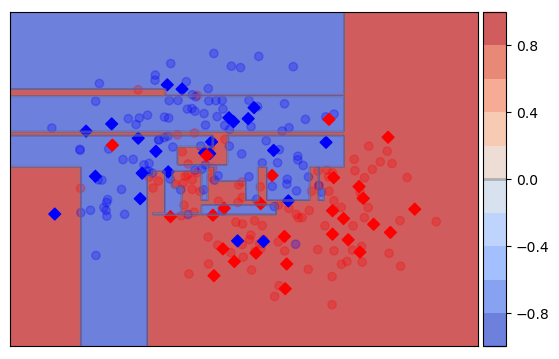

Test accuracy: 80.0% - Test precision: 79.3103448275862% - Test recall: 85.18518518518519% - Test F1-score: 82.14285714285714%


In [34]:
dt= DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_test_pred = dt.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

plot_decision_surface(X_train, y_train, X_test, y_test, dt)
print(f"Test accuracy: {test_accuracy*100}% - Test precision: {test_precision*100}% - Test recall: {test_recall*100}% - Test F1-score: {test_f1*100}%")

As the graphs shows, this overfitting manifests as an overly complex model with many splits that capture the noise rather than the underlying data patterns. The excessive complexity makes the tree less generalizable, resulting in lower accuracy, precision, recall, and other performance metrics on test data.
***
**How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?**

Noisy data can influence the SVM's decision boundary, making it more sensitive to data points near the boundary. With increased noise, support vectors, which determine the decision boundary, may include more noisy points. This sensitivity can affect the margin, causing it to become narrower as the SVM tries to accommodate these noisy points. Consequently, the model might overfit, capturing the noise in the training data rather than the underlying patterns.


Test accuracy: 86.00% - Test precision: 88.46% - Test recall: 85.19% - Test F1-score: 86.79%


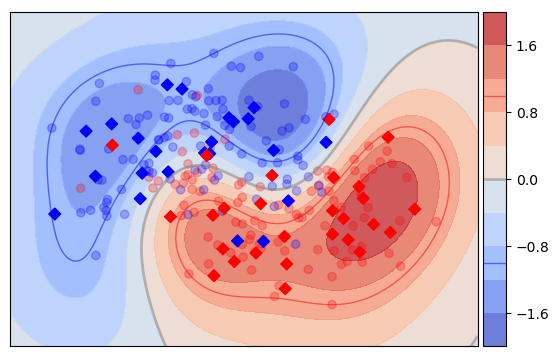

In [35]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

y_test_pred = svm.predict(X_test)

# Metrics for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test accuracy: {test_accuracy*100:.2f}% - Test precision: {test_precision*100:.2f}% - Test recall: {test_recall*100:.2f}% - Test F1-score: {test_f1*100:.2f}%")
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

The added noise in the dataset has resulted in a decrease in performance metrics: test accuracy is 86.0%, test precision is 88.5%, test recall is 85.2%, and the F1-score is 86.8%. Although the model captures the nonlinear patterns, it is now more susceptible to noise, as shown by the smoother, generalized decision boundaries compared to the previous boundaries.
***
**What strategies can be used to mitigate the effects of noise on these models?**

Data Preprocessing: Detecting and removing outliers can significantly reduce the noise in the dataset. Outliers can distort the model's learning process, leading to overfitting. 

Regularization: Applying regularization techniques like L1 (Lasso) or L2 (Ridge) can help prevent overfitting by penalizing large coefficients in the model. This constraint encourages the model to learn simpler patterns that generalize better to unseen data.

Cross-Validation: Using cross-validation helps in assessing the model's performance across multiple subsets of the data, ensuring that it generalizes well and is not overly influenced by any single noisy subset.

Ensemble Methods: Using methods like Random Forests or Gradient Boosting to average out predictions and increase robustness.

**Example of  Ensemble**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test accuracy: {round(test_accuracy*100, 2)}% - Test precision: {round(test_precision*100, 2)}% - Test recall: {round(test_recall*100, 2)}% - Test F1-score: {round(test_f1*100, 2)}%")

Test accuracy: 82.0% - Test precision: 82.14% - Test recall: 85.19% - Test F1-score: 83.64%


While Random Forests are designed to reduce overfitting by averaging multiple decision trees, making them more robust than a single tree, we observe only a slight improvement in performance metrics here (Test accuracy: 82.0%). This minor gain is overshadowed by the chaotic decision boundary introduced by the noisy dataset, leading to highly localized decision regions that do not generalize well.

<div class="alert alert-info"><b>Exercise 10: Adding a regularization term</b>

Now, it's time to explore the impact of hyperparameters on model performance. To understand the role of the `gamma` hyperparameter in SVM models, refer to [this resource](https://amagash.github.io/pages/exploration/supervised-learning/svm.html). Additionally, for a general understanding of regularization in supervised learning and SVMs in particular, check out these links: [Simplilearn's guide on regularization](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning) and [Wikipedia's overview](https://en.wikipedia.org/wiki/Regularization_perspectives_on_support_vector_machines).

Your task is to write a function called `get_metrics(model, X, y)`, where the first parameter is a pre-trained model, `X` is the feature matrix, and `y` is the target array. This function should return a dictionary containing key-value pairs for the following metrics: accuracy, precision for class 0 and class 1, recall for class 0 and class 1, and F1-score for class 0 and class 1. The dictionary should be structured as follows:

```python
{
   'accuracy': accuracy, 
   'precision_class_0': precision_class_0, 
   'precision_class_1': precision_class_1, 
   'recall_class_0': recall_class_0, 
   'recall_class_1': recall_class_1, 
   'f1_class_0': f1_class_0, 
   'f1_class_1': f1_class_1
}
```

Next, train three SVM models using the following values for the `gamma` parameter: `0.01`, `'scale'`, and `100`, while keeping the other hyperparameters at their default values. Store these models in a dictionary called `svm_models`, where each key is the corresponding `gamma` value and the value is the trained model. Use the function `get_metrics(model, X, y)` to generate two DataFrames `train_metrics`, and `test_metrics` to store performance metrics and its corresponding `gamma` value. Finally, find the model with the highest accuracy and store it in a variable called `best_svm`.

<br><i>[1 points]</i>
</div>

In [37]:
# YOUR CODE HERE
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def get_metrics(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision_class_0 = precision_score(y, y_pred, pos_label=0)
    precision_class_1 = precision_score(y, y_pred, pos_label=1)
    recall_class_0 = recall_score(y, y_pred, pos_label=0)
    recall_class_1 = recall_score(y, y_pred, pos_label=1)
    f1_class_0 = f1_score(y, y_pred, pos_label=0)
    f1_class_1 = f1_score(y, y_pred, pos_label=1)

    return {
        'accuracy': accuracy,
        'precision_class_0': precision_class_0,
        'precision_class_1': precision_class_1,
        'recall_class_0': recall_class_0,
        'recall_class_1': recall_class_1,
        'f1_class_0': f1_class_0,
        'f1_class_1': f1_class_1
    }

gamma = [0.01, 'scale', 100]
svm_models = {}

for i in gamma:
    model = svm.SVC(gamma=i)
    model.fit(X_train, y_train)
    svm_models[i] = model

train_metrics = pd.DataFrame([get_metrics(model, X_train, y_train) for model in svm_models.values()], 
                             index=gamma).reset_index().rename(columns={'index': 'gamma'})

test_metrics = pd.DataFrame([get_metrics(model, X_test, y_test) for model in svm_models.values()],
                            index=gamma).reset_index().rename(columns={'index': 'gamma'})

print("Train metrics:\n", train_metrics)
print("Test metrics:\n", test_metrics)

best_svm_index = test_metrics['accuracy'].idxmax()
best_svm = test_metrics.loc[best_svm_index, "gamma"]

print("\nModel with highest accuracy:", best_svm)

Train metrics:
    gamma  accuracy  precision_class_0  precision_class_1  recall_class_0  \
0   0.01     0.775           0.766355           0.784946        0.803922   
1  scale     0.855           0.868687           0.841584        0.843137   
2    100     0.975           0.961905           0.989474        0.990196   

   recall_class_1  f1_class_0  f1_class_1  
0        0.744898    0.784689    0.764398  
1        0.867347    0.855721    0.854271  
2        0.959184    0.975845    0.974093  
Test metrics:
    gamma  accuracy  precision_class_0  precision_class_1  recall_class_0  \
0   0.01      0.84           0.857143           0.827586        0.782609   
1  scale      0.86           0.833333           0.884615        0.869565   
2    100      0.70           0.681818           0.714286        0.652174   

   recall_class_1  f1_class_0  f1_class_1  
0        0.888889    0.818182    0.857143  
1        0.851852    0.851064    0.867925  
2        0.740741    0.666667    0.727273  

Model 

In [38]:
# LEAVE BLANK

In [39]:
# LEAVE BLANK

In [40]:
# LEAVE BLANK

In [41]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 11: Explain SVM regularization effect</b>

Provide well-reasoned answers to the following questions:

- How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?
- Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?
- How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?
- How do the test set metrics compare to the training set metrics for different `gamma` values? 
- Based on these observations, which model would you select, and why?
- What modifications could be made to improve the chosen model's performance on the noisy dataset?

<br><i>[1 points]</i>
</div>

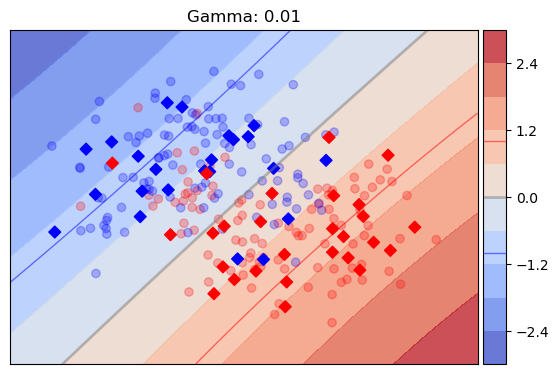

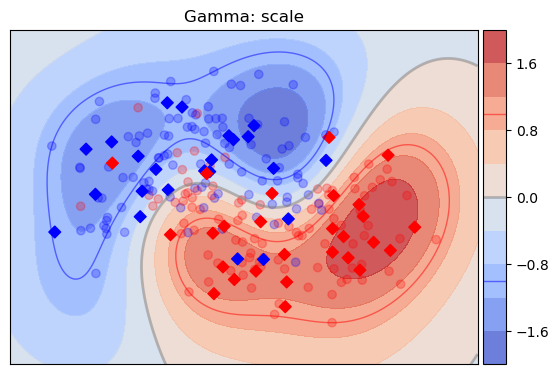

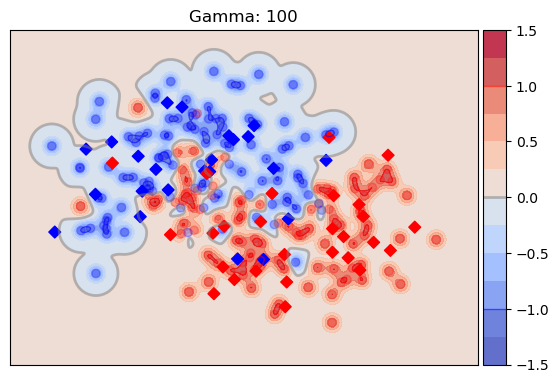

In [42]:
# DO NOT MODIFY THIS CELL. Simply execute it.
for svm in svm_models.values():
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f'Gamma: {svm.gamma}')

In [43]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')


**How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?**

Adjusting the gamma parameter alters the model's complexity by controlling the influence of individual data points on the decision boundary. A high gamma, like 100, creates a highly complex decision boundary that closely follows individual data points, including noise. This results in overfitting, where the model performs poorly on new data. Conversely, a low gamma, such as 0.01, produces a smoother, more generalized decision boundary by giving each data point a broader influence, reducing sensitivity to noise. This helps prevent overfitting but may lead to underfitting, as the model might be too simplistic to capture the data patterns. A moderate gamma, like "scale", strikes a balance by adapting to the actual shape of the data clusters without being overly sensitive to noise.
***
**Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?**

With a high gamma causes the boundary to trace each data point, including noise, leading to a jagged and sharply curved boundary around individual points where different classes mix. This represents an overfitted model, resulting in misclassifications when the model encounters new data that doesn't match the exact training set structure. On the other hand, with a low gamma, the decision boundary struggles to capture the curved structure of the data clusters, particularly in regions where red and blue points are intertwined. This results in misclassifications where classes overlap, indicating underfitting, especially in areas with close-proximity red and blue points. For the "scale" gamma, the boundary is more adaptable and follows the clusters of red and blue points without becoming overly specific. This gamma setting achieves a good balance.
***
**How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?**

As gamma increases, the balance between precision and recall shifts noticeably, with an excessively high gamma negatively impacting both metrics. At gamma = 0.01, the decision boundary is broad and generalized, leading to a precision of 82.8% and recall of 88.9% for the positive class. This configuration captures a wide range of positive instances, resulting in high recall but lower precision due to more false positives. With gamma = scale, the model achieves a balanced approach, effectively capturing the data structure and minimizing noise influence, yielding a precision of 88.5% and recall of 85.2% for the positive class. Conversely, with gamma = 100, the decision boundary becomes overly complex and sensitive to noise, causing both precision and recall to drop to 71.4% and 74.1%, respectively, for the positive class. This overfitting to noise leads to poor generalization and performance on new data, as illustrated by the parallel coordinates plots. The overfitted model (blue line) performs exceptionally well on the training set but fails on the test set.
***
**How do the test set metrics compare to the training set metrics for different `gamma` values?**

When gamma is set to 0.01, the decision boundary captures only the general trend of data separation, leading to balanced performance on both the training and test sets. With gamma set to 'scale,' the decision boundary becomes more adaptive, allowing the model to capture true data patterns without overfitting, achieving an optimal balance between precision and recall. However, when gamma is increased to a high value, such as 100, the model's performance on the test set declines. While training metrics remain high, the model struggles to generalize effectively, resulting in lower test performance.
***
**Based on these observations, which model would you select, and why?**

The model with gamma set to 'scale' is the best choice, as it strikes an ideal balance between complexity and generalization. This setting effectively captures the underlying data patterns without overfitting or underfitting, making it the most robust and reliable option.
***
**What modifications could be made to improve the chosen model's performance on the noisy dataset?**

We could fine-tune the regularization parameter C and gamma value to improve generalization, use cross-validation to identify optimal hyperparameters, and apply preprocessing to reduce noise.

<div class="alert alert-info"><b>Exercise 12: Increase size of dataset</b>

Now, let's retrain the least regularized SVM model with `gamma` set to 100, but this time using a larger dataset. Generate the dataset using the `make_moons` function with the parameters: `n_samples=2500`, `noise=0.4`, and `random_state=42`. Next, split the dataset into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility by using `random_state=42`. Store the resulting arrays as `X_train`, `X_test`, `y_train`, and `y_test`.

Fit the SVM model using the training data and store it in a variable called `non_regularized_svm`. Then, use the `get_metrics` function to compute the performance metrics, as done in the previous exercise, and append the results to the `train_metrics` and `test_metrics` dataframes.

Finally, add a new column named `dataset_size` to the metrics dataframes, assigning a value of `2500` for the new `non_regularized_svm` model and `250` for the previous models.

<br><i>[1 points]</i>
</div>

In [44]:
# YOUR CODE HERE
from sklearn import svm
X, y = make_moons(n_samples=2500, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

non_regularized_svm = svm.SVC(gamma=100)
non_regularized_svm.fit(X_train, y_train)

non_regularized_train_metrics = pd.DataFrame([get_metrics(non_regularized_svm, X_train, y_train)])
non_regularized_train_metrics["gamma"] = 100
non_regularized_train_metrics["dataset_size"] = 2500

non_regularized_test_metrics = pd.DataFrame([get_metrics(non_regularized_svm, X_test, y_test)])
non_regularized_test_metrics["gamma"] = 100
non_regularized_test_metrics["dataset_size"] = 2500

train_metrics["dataset_size"] = 250
test_metrics["dataset_size"] = 250

train_metrics = pd.concat([train_metrics, non_regularized_train_metrics])
test_metrics = pd.concat([test_metrics, non_regularized_test_metrics ])

print("training metrics: \n", train_metrics)
print("testing metrics: \n", test_metrics)

training metrics: 
    gamma  accuracy  precision_class_0  precision_class_1  recall_class_0  \
0   0.01     0.775           0.766355           0.784946        0.803922   
1  scale     0.855           0.868687           0.841584        0.843137   
2    100     0.975           0.961905           0.989474        0.990196   
0    100     0.886           0.880881           0.891109        0.889788   

   recall_class_1  f1_class_0  f1_class_1  dataset_size  
0        0.744898    0.784689    0.764398           250  
1        0.867347    0.855721    0.854271           250  
2        0.959184    0.975845    0.974093           250  
0        0.882295    0.885312    0.886680          2500  
testing metrics: 
    gamma  accuracy  precision_class_0  precision_class_1  recall_class_0  \
0   0.01     0.840           0.857143           0.827586        0.782609   
1  scale     0.860           0.833333           0.884615        0.869565   
2    100     0.700           0.681818           0.714286      

In [45]:
# LEAVE BLANK

In [46]:
# LEAVE BLANK


In [47]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 13: Explain size of dataset</b>

Provide well-reasoned answers to the following questions:

- How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?
- As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?
- How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?
- Is there a point where adding more data stops providing significant improvements in performance?
- Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?
- How does the increase in data help the model create a smoother decision boundary?
- Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?
- In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?
- After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?"

  

<br><i>[1 points]</i>
</div>
<div class="alert alert-warning">

The `plot_decision_surface` function may take up to 30 seconds to complete. Please be patient, this is expected behavior.

</div>


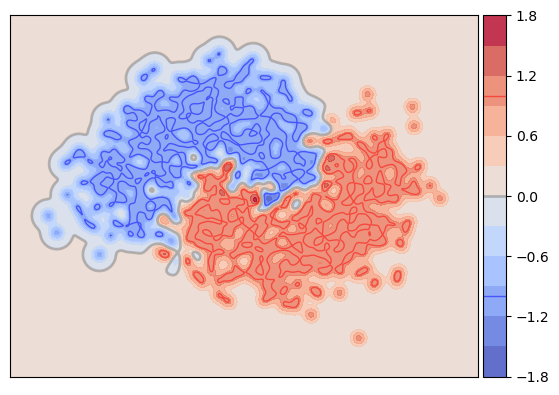

In [48]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, non_regularized_svm, show_points=False)

In [49]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

**How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?**

Increasing the dataset size helps to reduce overfitting and improve the model’s test performance by providing a more comprehensive and diverse representation of the data. This larger dataset mitigates the impact of noise and encourages the model to focus on genuine data patterns rather than memorizing anomalies. We can compare both models with high gamma. Using the smaller dataset, the model achieved a very high training accuracy of 97.5% but only 70% on the test set, highlighting its failure to generalize well due to overfitting. However, after increasing the dataset size to 2500 samples, the training accuracy decreased to 88.6%, while the test accuracy significantly improved to 85.2%. This more balanced performance indicates that the model better captures the underlying data structure, leading to enhanced generalization.

***
**As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?**

As more data is added, the SVM's decision boundary smooths out, as the model gains a clearer understanding of the underlying data patterns. This enhanced representation reduces its sensitivity to noise and outliers. Consequently, with the larger dataset of 2500 samples, the model demonstrates better generalization, even with a high gamma value like 100.

***
**How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?**

For the smaller dataset (250 samples), the model demonstrates high training accuracy at 97.5% but significantly lower test accuracy at 70%, indicating overfitting. When the dataset size increases to 2500 samples, the training accuracy decreases slightly to 88.6%, while the test accuracy improves to 85.2%, aligning the train and test performances more closely. As the sample size grows, the test metrics improve, and the training metrics decrease slightly, which reduces overfitting and enhances the model's generalization. 
***
**Is there a point where adding more data stops providing significant improvements in performance?**

Yes, eventually adding more data reaches a point of diminishing returns where performance improvements become minimal. This often happens when the model is already well-generalized for the complexity of the data.
***
**Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?**

Increasing the dataset size provides a more diverse and extensive sample of the underlying data distribution, allowing the SVM model to learn the general patterns rather than overfitting to specific, potentially noisy patterns. This helps counterbalance the high gamma value by offering more information for the model to generalize.
***
**How does the increase in data help the model create a smoother decision boundary?**

With more data, the model captures the overall structure of the data distribution better, making it less sensitive to individual points or noise. This additional information allows the decision boundary to smooth out, as the model becomes less focused on isolated points. Consequently, the SVM can create a margin that separates the classes more effectively.
***
**Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?**

Given that increasing the dataset size to 2500 samples significantly improved the model’s performance and reduced overfitting, lowering the gamma value may not be necessary. The closer alignment between training and test performance indicates that the model is already generalizing well. Therefore, in this instance, increasing the dataset size alone appears to be sufficient.

In [50]:
# Try the SVM model with gamma="scale"
non_regularized_svm_scale = svm.SVC(gamma="scale")
non_regularized_svm_scale.fit(X_train, y_train)

non_regularized_train_metrics_scale = pd.DataFrame([get_metrics(non_regularized_svm_scale, X_train, y_train)])
non_regularized_train_metrics_scale["gamma"] = "scale"
non_regularized_train_metrics_scale["dataset_size"] = 2500

non_regularized_test_metrics_scale = pd.DataFrame([get_metrics(non_regularized_svm_scale, X_test, y_test)])
non_regularized_test_metrics_scale["gamma"] = "scale"
non_regularized_test_metrics_scale["dataset_size"] = 2500

# Concatenate the new metrics with existing DataFrames
train_metrics = pd.concat([train_metrics, non_regularized_train_metrics_scale])
test_metrics = pd.concat([test_metrics, non_regularized_test_metrics_scale])

print("Training metrics: \n", train_metrics)
print("Testing metrics: \n", test_metrics)

Training metrics: 
    gamma  accuracy  precision_class_0  precision_class_1  recall_class_0  \
0   0.01     0.775           0.766355           0.784946        0.803922   
1  scale     0.855           0.868687           0.841584        0.843137   
2    100     0.975           0.961905           0.989474        0.990196   
0    100     0.886           0.880881           0.891109        0.889788   
0  scale     0.863           0.861476           0.864491        0.861476   

   recall_class_1  f1_class_0  f1_class_1  dataset_size  
0        0.744898    0.784689    0.764398           250  
1        0.867347    0.855721    0.854271           250  
2        0.959184    0.975845    0.974093           250  
0        0.882295    0.885312    0.886680          2500  
0        0.864491    0.861476    0.864491          2500  
Testing metrics: 
    gamma  accuracy  precision_class_0  precision_class_1  recall_class_0  \
0   0.01     0.840           0.857143           0.827586        0.782609   
1  s

The minimal difference in metrics between the gamma='scale' SVM model on the smaller dataset (250 samples) and the larger dataset (2500 samples) indicates that the gamma='scale' model was already well-generalized with the smaller dataset. This implies that the gamma='scale' setting did not result in significant overfitting even with the initial smaller dataset.
***

**In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?**

Increasing the dataset size alone may not be enough when the model's complexity doesn’t match the data’s structure. We can consider a scenario involving handwritten digit recognition. Suppose we originally trained an SVM model with gamma set to 100 on a small dataset of 500 images, achieving high training accuracy but poor test accuracy due to overfitting. By increasing the dataset size to 5000 images, we observe a significant improvement in test accuracy and a slight decrease in training accuracy, indicating better generalization. However, if we set the gamma to "scale" and trained the model on the initial 500 images, we might have seen well-balanced performance metrics even without increasing the dataset size.
***
**After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?**

The SVM model with gamma set to "scale" remains the preferable choice over the high-gamma, large-sample model. While increasing the dataset size did help the high-gamma model generalize better, it’s often impractical to simply add more data in real-world scenarios. Most datasets come with fixed sizes, so optimizing model performance by tuning hyperparameters like C and gamma is generally more feasible.